In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 11:20:50.914297: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 11:20:52.194093: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [8]:
start_idx = 5400
end_idx = 5550
duration = end_idx - start_idx

In [9]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(150, 96)

In [10]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [11]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [12]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(150, 96, 7)
(100800,)


In [13]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(150, 96, 2)


In [14]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(150, 96, 3)


### GA

In [15]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 11:21:15.893002: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


In [16]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [17]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [18]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [19]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 11:21:19.938465: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step
CPU time: 3183.380120632006 seconds


In [20]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

5/5 [==============================] - 0s 4ms/step
Parameters of the best solution : [0.84272251 0.409454   0.64946094 ... 0.99035244 0.75422418 0.4302861 ]
Fitness value of the best solution = 0.001710981615444512


### Post-processing

In [21]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

5/5 [==============================] - 0s 4ms/step


In [22]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


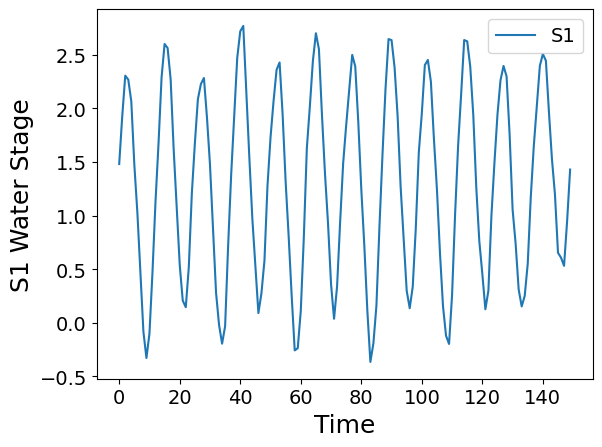

In [23]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [24]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low9.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.842723,0.409454,0.649461,0.572361,0.787536,0.603933,0.336883,0.459464,0.121874,0.798298,...,0.925284,0.528050,0.636157,0.921970,0.956747,0.366221,0.848574,0.402785,0.076325,0.636161
1,0.849166,0.961047,0.123738,0.130045,0.730673,0.374807,0.292574,0.208010,0.094059,0.953396,...,0.962208,0.977080,0.387809,0.401598,0.944985,0.306990,0.616789,0.422545,0.713407,0.603466
2,0.472734,0.475218,0.165339,0.809745,0.722022,0.339487,0.144606,0.398940,0.492727,0.347010,...,0.611905,0.337300,0.969414,0.547629,0.292382,0.304251,0.830082,0.816285,0.615229,0.643650
3,0.569799,0.972373,0.738643,0.445462,0.081987,0.958712,0.295350,0.524296,0.103791,0.955414,...,0.456445,0.939546,0.675544,0.864656,0.785354,0.543540,0.749129,0.544120,0.866072,0.733237
4,0.543666,0.970292,0.558406,0.356105,0.966312,0.693324,0.974476,0.605511,0.214179,0.919481,...,0.453666,0.608320,0.878703,0.159283,0.285662,0.024589,0.784805,0.785407,0.956988,0.637260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.975337,0.819897,0.696429,0.452349,0.582545,0.734707,0.789303,0.999720,0.513954,0.366706,...,0.836406,0.524981,0.163741,0.390156,0.285260,0.283960,0.916014,0.227515,0.676203,0.807245
146,0.995408,0.159467,0.503721,0.383570,0.447045,0.195351,0.809009,0.550469,0.368137,0.714545,...,0.302732,0.179751,0.595537,0.171540,0.934939,0.225089,0.920909,0.428229,0.478952,0.992857
147,0.770824,0.979113,0.863975,0.231040,0.105645,0.492242,0.633629,0.565848,0.111388,0.750557,...,0.041272,0.514118,0.567719,0.107945,0.308972,0.476595,0.843288,0.930143,0.057829,0.767517
148,0.890268,0.571068,0.460296,0.542948,0.595182,0.685273,0.065045,0.880614,0.753514,0.366076,...,0.391465,0.009985,0.888985,0.179319,0.152021,0.634523,0.086169,0.821025,0.479298,0.785102


In [25]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low9.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,1.480119,1.490862,1.475731,1.456603,1.993992,2.207071,1.936218,1.948383,2.285652,2.150665,...,0.372550,0.305731,0.296943,0.370763,0.437034,0.404462,0.564046,0.799893,0.633856,0.587113
1,1.923313,2.071238,1.906483,1.926216,2.314558,2.387998,2.227527,2.310896,2.360061,2.515172,...,0.400929,0.262084,0.566434,0.929545,0.741580,0.680329,1.039661,1.136732,1.122556,1.090822
2,2.303862,2.290757,2.306498,2.309377,2.338518,2.300140,2.286814,2.297175,2.217054,2.298666,...,0.494160,0.391806,1.015999,1.229075,1.021225,1.077173,1.582886,1.693067,1.556373,1.655155
3,2.266759,2.192850,2.288917,2.338184,2.068310,2.133016,2.043590,2.098806,1.466272,1.601498,...,1.106913,1.113935,1.630389,1.715892,1.668207,1.757882,1.952690,2.124893,2.029008,2.070366
4,2.063010,2.045284,2.047137,2.022143,1.547801,1.481325,1.607471,1.541028,0.979564,0.892572,...,1.571743,1.605261,1.970366,2.172108,1.910905,2.004197,2.209711,2.238310,2.208955,2.333460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.652657,0.928847,0.697663,0.622518,0.495637,0.379003,0.501227,0.453970,0.614265,0.466418,...,2.174257,2.291427,1.897445,2.034233,1.955563,2.035706,1.487839,1.508192,1.627325,1.636805
146,0.606957,0.595167,0.609845,0.595910,0.632765,0.518219,0.539666,0.597313,1.014107,1.069193,...,1.930090,1.942584,1.543293,1.678752,1.641060,1.669368,1.129026,1.065932,1.349373,1.289503
147,0.530994,0.489493,0.544881,0.494461,0.881952,0.850484,0.746851,0.879809,1.495956,1.204054,...,1.777903,1.691353,1.113627,1.304937,1.378741,1.269040,0.761846,0.613102,1.016757,0.959948
148,0.943171,0.760918,0.969000,1.021460,1.435074,1.447020,1.262877,1.527861,1.822241,1.527564,...,1.284667,1.307028,0.697580,0.871396,0.960409,0.950547,0.604318,0.482705,0.845879,0.936074


In [26]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 610, areas: 85.87630946224454


In [27]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

5/5 [==============================] - 0s 4ms/step
time steps: 0, areas: 0
time steps: 1088, areas: 243.91841090320668
